In [1]:
import pandas as pd
##Pre-processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

#Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_auc_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.sparse import csr_matrix, hstack
from scipy.stats import ks_2samp


#Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
import xgboost as xgb

#All Purpose
import numpy as np
import pickle
import seaborn as sns
import warnings
import joblib
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

E:\Softwares\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading Train_Test Split  Data

 - As part of gender prediction data was encoded and numerical columns were scaled to same range of values.
 - Data was also split into train and test which can be used here directly.

In [2]:
#Reading Saved Testing Data
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Train_Test_Data\Scenario 2'
df_s2_data_train = pd.read_csv(f'{path}\\df_s2_data_train.csv')
df_s2_data_train.shape

(40988, 1473)

In [3]:
df_s2_data_train.drop('train_test_flag',axis=1,inplace=True)
df_s2_data_train.shape

(40988, 1472)

### Why Classification Model Was Chosen for Age Prediction

- Age prediction is subjective and depends on various factors such as genetics, lifestyle, health, etc. Therefore, it is hard to define a precise age for a person based on their appearance.
- Age prediction is often used for applications that do not require exact age, but rather a rough estimate or a range. For example, age-based marketing, face verification, demographic analysis, etc.
- Classification can reduce the error and variance of the prediction by grouping similar ages into bins or categories. For example, instead of predicting 23 or 24 years old, we can predict 20-25 years old as a class.


In [4]:
def create_age_bins(age):
    if 0<= age <= 24:
        return 0 #for 0-24
    elif 25<= age <= 32:
        return 1 #for 25-32
    elif age > 32:
        return 2 #for 32+
        

In [5]:
#Reading Saved Test Data
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Train_Test_Data\Scenario 2'
df_s2_data_test = pd.read_csv(f'{path}\\df_s2_data_test.csv')
df_s2_data_test.shape

(10251, 1473)

In [6]:
df_s2_data_test.drop('train_test_flag',axis=1,inplace=True)
df_s2_data_test.shape

(10251, 1472)

In [7]:
#Separating target variables with features for training data
#For Male we would be denoting by 1 and for female by 0
X_train_s2 = df_s2_data_train.drop(columns= ['gender','age','device_id'],axis=1)
Y_train_s2_age = df_s2_data_train['age'].apply(lambda x:create_age_bins(x))
Y_train_s2_age
print(X_train_s2.shape)
print(Y_train_s2_age.shape)


(40988, 1469)
(40988,)


In [8]:
#Separating target variables with features for test data
X_test_s2 = df_s2_data_test.drop(columns= ['gender','age','device_id'],axis=1)
Y_test_s2_age = df_s2_data_test['age'].apply(lambda x:create_age_bins(x))
print(X_test_s2.shape)
print(Y_test_s2_age.shape)


(10251, 1469)
(10251,)


### Creating Helper Functions for Model Evaluation

In [9]:
#Below dict will contain all the evaluation metrics for each model which would be later used for comparison
model_evaluation_dict_age = {
    'Model_Name':[],
    'Training_Accuracy':[],
    'Testing_Accuracy':[],
    'Precision_Training':[],
    'Precision_Testing':[],
    'Recall_Training':[],
    'Recall_Testing':[],
    'F1Score_Training':[],
    'F1Score_Testing':[],
    'Multiclass_log_loss_Training':[],
    'Multiclass_log_loss_Testing':[],
}

In [10]:
def multiclass_log_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    N = len(y_true)
    loss = -np.sum(y_true * np.log(y_pred)) / N
    return loss

In [11]:
def evaluate_model(model, data, y_true, isTraining=True):
    label = 'Training' if isTraining else 'Testing'
    
    print(f'Evaluating {label} performance')
    
    #Prediciting target variable on training data
    y_pred = model.predict(data)
    #Calculating Accuracy
    accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    print(f'Accuracy:{accuracy}')
    
    #Calculating Precision and Recall Score
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    print(f'Precision:{precision}')
    print(f'Recall:{recall}')
    
    #Calculating F1-Score
    f1 = f1_score(y_true, y_pred,average='weighted')
    print(f'F1Score:{f1}')
    
    #Plotting Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
        
    #Evaluating log loss
    log_loss = multiclass_log_loss(y_true, y_pred) 
    
    #Adding above generated evaluation metrics to the model_evaluation_dict_age
    model_evaluation_dict_age[f'{label}_Accuracy'].append(accuracy)
    model_evaluation_dict_age[f'Precision_{label}'].append(precision)
    model_evaluation_dict_age[f'Recall_{label}'].append(recall)
    model_evaluation_dict_age[f'F1Score_{label}'].append(f1)
    model_evaluation_dict_age[f'Multiclass_log_loss_{label}'].append(log_loss)


### Logistic Regression Model for Predicting `Age` for Scenario 2

- Logistic regression model will be used as a benchmark to compare the other Machine learning models.

In [12]:
Y_train_s2_age.value_counts()

1    16857
2    13549
0    10582
Name: age, dtype: int64

- We have an unbalanced data set as values are not equally distributed among different age bins.

In [13]:
#As it is an unbalanced data set compute the appropiate class weight to be assigned to the model
weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_train_s2_age),y = Y_train_s2_age)
print(weights)
class_weights = dict(zip(np.unique(Y_train_s2_age), weights))
print(class_weights)

[1.29112329 0.81050404 1.0083893 ]
{0: 1.291123291123291, 1: 0.8105040438195804, 2: 1.0083893030235933}


In [21]:
#Declaring the Logistic Regression Model and training the model on the train data
lr_model = LogisticRegression(class_weight = class_weights, random_state=100, max_iter=1500)
lr_model.fit(X_train_s2, Y_train_s2_age)

LogisticRegression(class_weight={0: 1.291123291123291, 1: 0.8105040438195804,
                                 2: 1.0083893030235933},
                   max_iter=1500, random_state=100)

In [22]:
lr_model.classes_

array([0, 1, 2], dtype=int64)

In [23]:
# Saving the Logistic Regression Model as a pickle in a file
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\Logistic_Regression_Age_Scenario2.pkl'
pickle.dump(lr_model, open(filename, 'wb'))

In [14]:
# Reading saved Logistic regression model
# path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
# filename = f'{path}\\Logistic_Regression_Age_Scenario2.pkl'
# lr_model = pickle.load(open(filename, 'rb'))
# print(lr_model)

LogisticRegression(class_weight={0: 1.291123291123291, 1: 0.8105040438195804,
                                 2: 1.0083893030235933},
                   max_iter=1500, random_state=100)


#### Evaluating the Logistic Regression classifier on Training Data Set

Evaluating Training performance
Accuracy:0.4445194766800588
Precision:0.4475920675796427
Recall:0.4256367717380697
F1Score:0.41699957804105453


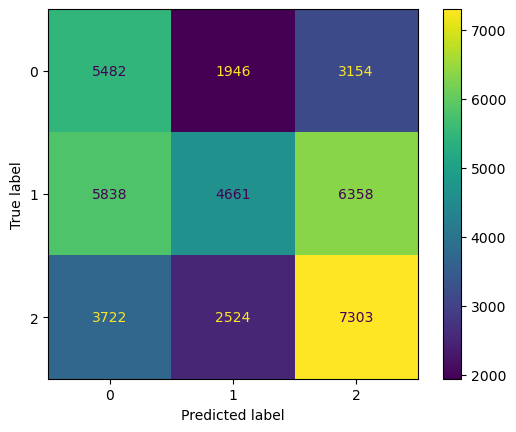

In [15]:
model_evaluation_dict_age['Model_Name'].append('Logistic_Regression')
evaluate_model(lr_model, X_train_s2, Y_train_s2_age)

#### Evaluating the Logistic Regression classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.4101744160218425
Precision:0.4070661873738583
Recall:0.3924495171202809
F1Score:0.3835362643606653


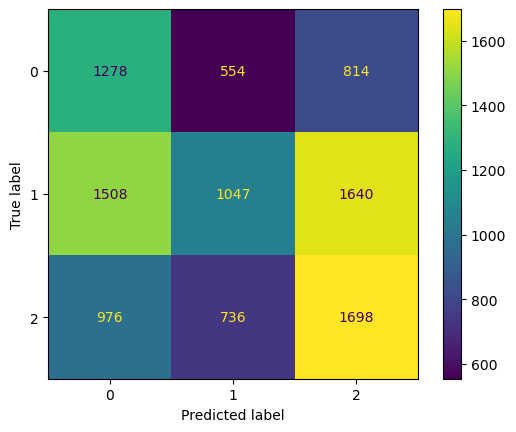

In [16]:
evaluate_model(lr_model, X_test_s2, Y_test_s2_age, False)

### XGBoost Model for Predicting `Age` for Scenario 2

In [28]:
#Training XGBoost Model on train data
xgclf = xgb.XGBClassifier(random_state=100,n_jobs=-1)
xgclf.fit(X_train_s2, Y_train_s2_age)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [30]:
# Saving the XGBoost Model as a pickle in a file
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\XGBoost_Age_Scenario2.pkl'
pickle.dump(xgclf, open(filename, 'wb'))
print(xgclf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [17]:
# Reading saved XGBoost model
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\XGBoost_Age_Scenario2.pkl'
xgclf = pickle.load(open(filename, 'rb'))
print(xgclf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


#### Evaluating the XGBoost classifier on Training Data Set

Evaluating Training performance
Accuracy:0.3764726195356558
Precision:0.48184853688668106
Recall:0.4427393383429296
F1Score:0.349627483412001


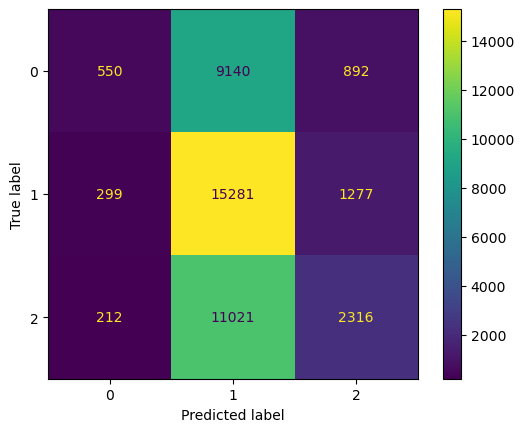

In [18]:
model_evaluation_dict_age['Model_Name'].append('XGBoost_Basic')
evaluate_model(xgclf, X_train_s2, Y_train_s2_age)

#### Evaluating the XGBoost classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.3516997140246601
Precision:0.40608877006287336
Recall:0.41625207296849087
F1Score:0.31543322877659735


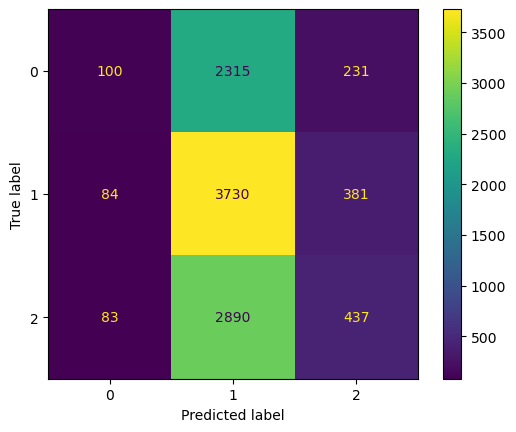

In [19]:
evaluate_model(xgclf, X_test_s2, Y_test_s2_age, False)

### HyperParemter Tuning XGBoost Model for Predicting `Age` for Scenario 2

In [22]:
#StratifiedKFold is used as we want the folds to be created to have the same proportion of class lables as in the data.
cross_validation = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)

In [30]:
#Creating parameter grid
param_grid = {

    'min_child_weight': [1, 5],

    'gamma': [0.5, 1, 1.5, 2, 5],

    'colsample_by_tree': [0.6, 0.8, 1.0],

    'max_depth': [3, 4],

    'n_estimators': range(60, 180, 30),

    'learning_rate': [0.1, 0.01, 0.05],

 }

In [31]:
#Training XGBoost Model
xgb_model = xgb.XGBClassifier()
clf_xgb_grid = RandomizedSearchCV(xgb_model,
                              param_grid,
                               cv=cross_validation,
                               verbose=4,
                               n_jobs=-1,
                               random_state = 100,
                               error_score="raise")
clf_xgb_grid.fit(X_train_s2, Y_train_s2_age)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[19:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.



RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_by_tree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': [3, 4],
                                        'min_child_weight': [1, 5],
                                        'n_estimators': range(60, 180, 30)},
                   random_state=100, verbose=4)

In [32]:
print(clf_xgb_grid.best_params_)
print(clf_xgb_grid.best_score_)
print(clf_xgb_grid.best_estimator_)
best_clf_xgb_grid = clf_xgb_grid.best_estimator_
xgb_hpt = best_clf_xgb_grid

{'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_by_tree': 1.0}
0.414999512052308
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_by_tree=1.0, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', ...)


In [33]:
#Saving the model
#Uncomment below if running for first time and saved model is not present.
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\XGBoostHPT_Age_Scenario2.pkl'
pickle.dump(best_clf_xgb_grid, open(filename, 'wb'))

In [34]:
#Reading saved model for XGBoost with Grid Search
# path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
# filename = f'{path}\\XGBoostHPT_Age_Scenario2.pkl'
# xgb_hpt = pickle.load(open(filename, 'rb'))
# print(xgb_hpt)

#### Evaluating the XGBoost with HyperParameter Tuning classifier on Training Data Set

Evaluating Training performance
Accuracy:0.34017880999072486
Precision:0.3914113331678382
Recall:0.4118622573407472
F1Score:0.2739710946719543


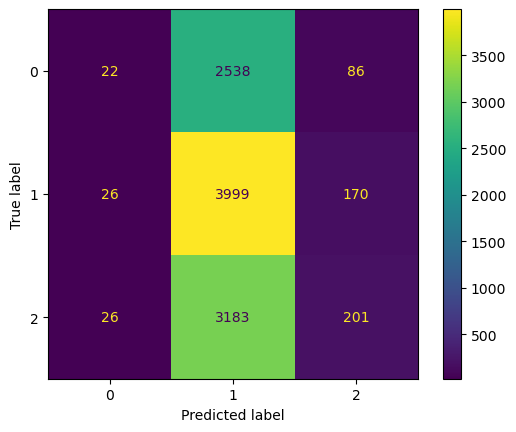

In [35]:
model_evaluation_dict_age['Model_Name'].append('XGBoost_HPT')
evaluate_model(xgb_hpt, X_test_s2, Y_test_s2_age)

#### Evaluating the XGBoost with Hyper Parameter Tuning on Test Data Set

Evaluating Testing performance
Accuracy:0.34017880999072486
Precision:0.3914113331678382
Recall:0.4118622573407472
F1Score:0.2739710946719543


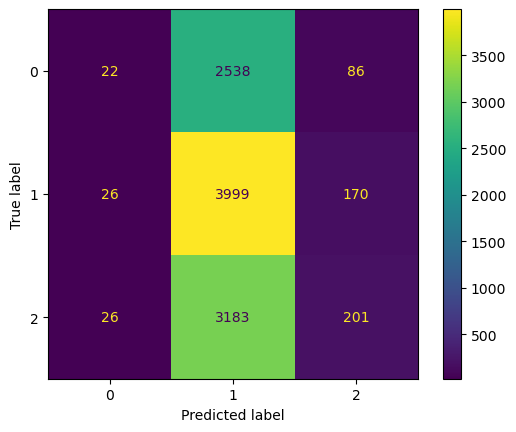

In [36]:
evaluate_model(xgb_hpt, X_test_s2, Y_test_s2_age, False)

### Stacking Classifier Model for Predicting `Age` for Scenario 2

In [23]:
# 1st set of models
clf1 = LogisticRegression(class_weight = class_weights, random_state=100)
clf2 = RandomForestClassifier(class_weight = class_weights,random_state=100,n_jobs=-1)
xgb_m = xgb.XGBClassifier()

stacking_classifier = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_m, use_probas=True, cv=cross_validation, random_state=100)

In [24]:
#Training Stacking Classifier Model on train data
# Performing Cross Validation on Stacking Classifier

for clf, label in zip([clf1, clf2, stacking_classifier], 
                      ['lr', 
                       'Random Forest', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train_s2, Y_train_s2_age, cv=cross_validation, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.38 (+/- 0.00) [lr]
Accuracy: 0.38 (+/- 0.00) [Random Forest]
Accuracy: 0.40 (+/- 0.00) [StackingClassifier]


In [25]:
#Fitting the Stacking Classifier on Training Data
sclf_fit = stacking_classifier.fit(X_train_s2, Y_train_s2_age)

In [26]:
# Saving the Stacking Classifier Model as a pickle in a file
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
filename = f'{path}\\Stacking_Classifier_Age_Scenario2.pkl'
pickle.dump(sclf_fit, open(filename, 'wb'))

In [ ]:
# Reading saved Stacking Classifier model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\Stacking_Classifier_Age_Scenario2.pkl'
# sclf_fit = pickle.load(open(filename, 'rb'))
# print(sclf_fit)

#### Evaluating the Stacking Classifier on Training Data Set

Evaluating Training performance
Accuracy:0.3812142111120169
Precision:0.41776116032875615
Recall:0.42363618620083926
F1Score:0.38953668354115467


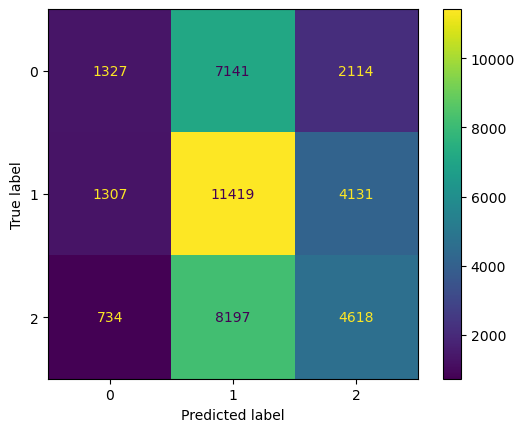

In [27]:
model_evaluation_dict_age['Model_Name'].append('Stacking_Classifier')
evaluate_model(sclf_fit,X_train_s2, Y_train_s2_age)

#### Evaluating the Stacking Classifier Model on Test Data Set

Evaluating Testing performance
Accuracy:0.37599260946106083
Precision:0.40813180768831386
Recall:0.4188859623451371
F1Score:0.38254191547787514


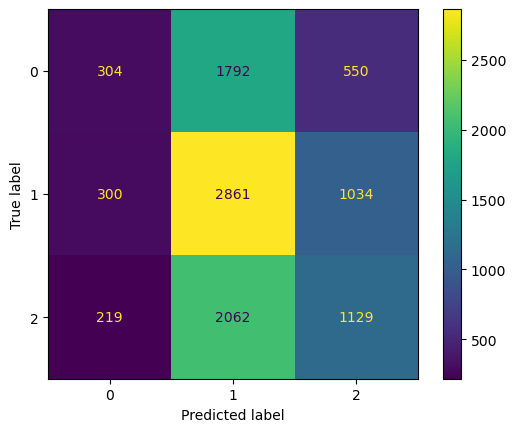

In [28]:
evaluate_model(sclf_fit, X_test_s2, Y_test_s2_age, False)

### Evaluation Metrics

In [37]:
model_evaluation_dict_age

{'Model_Name': ['Logistic_Regression',
  'XGBoost_Basic',
  'Stacking_Classifier',
  'XGBoost_HPT'],
 'Training_Accuracy': [0.4445194766800588,
  0.3764726195356558,
  0.3812142111120169,
  0.34017880999072486],
 'Testing_Accuracy': [0.4101744160218425,
  0.3516997140246601,
  0.37599260946106083,
  0.34017880999072486],
 'Precision_Training': [0.4475920675796427,
  0.48184853688668106,
  0.41776116032875615,
  0.3914113331678382],
 'Precision_Testing': [0.4070661873738583,
  0.40608877006287336,
  0.40813180768831386,
  0.3914113331678382],
 'Recall_Training': [0.4256367717380697,
  0.4427393383429296,
  0.42363618620083926,
  0.4118622573407472],
 'Recall_Testing': [0.3924495171202809,
  0.41625207296849087,
  0.4188859623451371,
  0.4118622573407472],
 'F1Score_Training': [0.41699957804105453,
  0.349627483412001,
  0.38953668354115467,
  0.2739710946719543],
 'F1Score_Testing': [0.3835362643606653,
  0.31543322877659735,
  0.38254191547787514,
  0.2739710946719543],
 'Multiclass_lo

In [38]:
df_evaluation_age_s2 = pd.DataFrame(model_evaluation_dict_age)
df_evaluation_age_s2

,Model_Name,Training_Accuracy,Testing_Accuracy,Precision_Training,Precision_Testing,Recall_Training,Recall_Testing,F1Score_Training,F1Score_Testing,Multiclass_log_loss_Training,Multiclass_log_loss_Testing
0,Logistic_Regression,0.444519,0.410174,0.447592,0.407066,0.425637,0.392450,0.417000,0.383536,11.192154,11.657806
1,XGBoost_Basic,0.376473,0.351700,0.481849,0.406089,0.442739,0.416252,0.349627,0.315433,0.609240,0.842327
2,Stacking_Classifier,0.381214,0.375993,0.417761,0.408132,0.423636,0.418886,0.389537,0.382542,2.338370,2.486549
3,XGBoost_HPT,0.340179,0.340179,0.391411,0.391411,0.411862,0.411862,0.273971,0.273971,0.262806,0.262806


In [39]:
path = 'E:\Shobhit\MSDS\Capstone\Y1_Capstone\MLModels\Age Prediction'
df_evaluation_age_s2.to_csv(f'{path}\\evaluation_metrics_age_s2.csv',index=False)